In [1]:
import os
os.environ['KAGGLE_USERNAME'] = ''  # Your Kaggle username
os.environ['KAGGLE_KEY'] = ''  # Your Kaggle API key
os.environ['URN'] = '6644818'  # Your URN: submissions without a URN will not count

#!kaggle competitions download -c uos-com2028-21-22-cw
#!unzip uos-com2028-21-22-cw.zip

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, utils
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical
from tensorflow.data import AUTOTUNE

import random
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

2022-04-09 15:10:56.725226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 15:10:56.754331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 15:10:56.754486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Read the data

In [3]:
color_mode = 'grayscale'
image_size = (28, 28)
image_shape = (*image_size, 1)
batch_size = 1000

num_classes = 8

In [4]:
#read all labels
train_labels_dp = pd.read_csv('train.csv')
train_labels = tf.constant(train_labels_dp.loc[:, 'Cell type'].values)

2022-04-09 15:10:56.793390: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-09 15:10:56.793958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 15:10:56.794232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 15:10:56.794423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [5]:
#based on https://www.tensorflow.org/tutorials/load_data/images

def pathToLabel(path):
  path = tf.strings.regex_replace(path, "./train/", "")
  path = tf.strings.regex_replace(path, ".jpg", "")
  return train_labels[tf.strings.to_number(path, out_type=tf.int32)]

def decode_image(img):
  # channels were reduced to 1 since image is grayscale
  img = tf.io.decode_jpeg(img, channels=1)

  return tf.image.resize(img, image_size)

@tf.function
def process_path(path, addPath=False):
  label = pathToLabel(path)

  print (label)

  img = tf.io.read_file(path)
  img = decode_image(img)

  if addPath:
    return img, label, path
  else:
    return img, [float(label)] * 50, label

def configure_for_performance(ds: tf.data.Dataset) -> tf.data.Dataset:
  #ds = ds.cache()
  ds = ds.shuffle(buffer_size= 1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(AUTOTUNE)
  return ds

def prepare_dataset(ds: tf.data.Dataset) -> tf.data.Dataset:
  ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
  ds = configure_for_performance(ds)
  return ds
  

In [6]:
# https://www.tensorflow.org/tutorials/keras/regression
def plot_loss(history, val=True, color="b", save=False):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['accuracy'], label='accuracy')
  if val:
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('error')
  plt.legend()
  plt.grid(True)
  if save:
    plt.savefig('./fig.png')
  else:
    plt.show()

In [7]:
seed = random.randint(0, 10000)

print("seed: %d" % seed)

# Read all the files from the direcotry
list_ds = tf.data.Dataset.list_files(str('./train/*'), shuffle=False)

image_count = len(list_ds)

list_ds = list_ds.shuffle(image_count, seed=seed)

val_size = int(image_count * 0.1)

train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

train_ds = prepare_dataset(train_ds)
val_ds   = prepare_dataset(val_ds)


seed: 8200
Tensor("strided_slice:0", shape=(), dtype=int64)


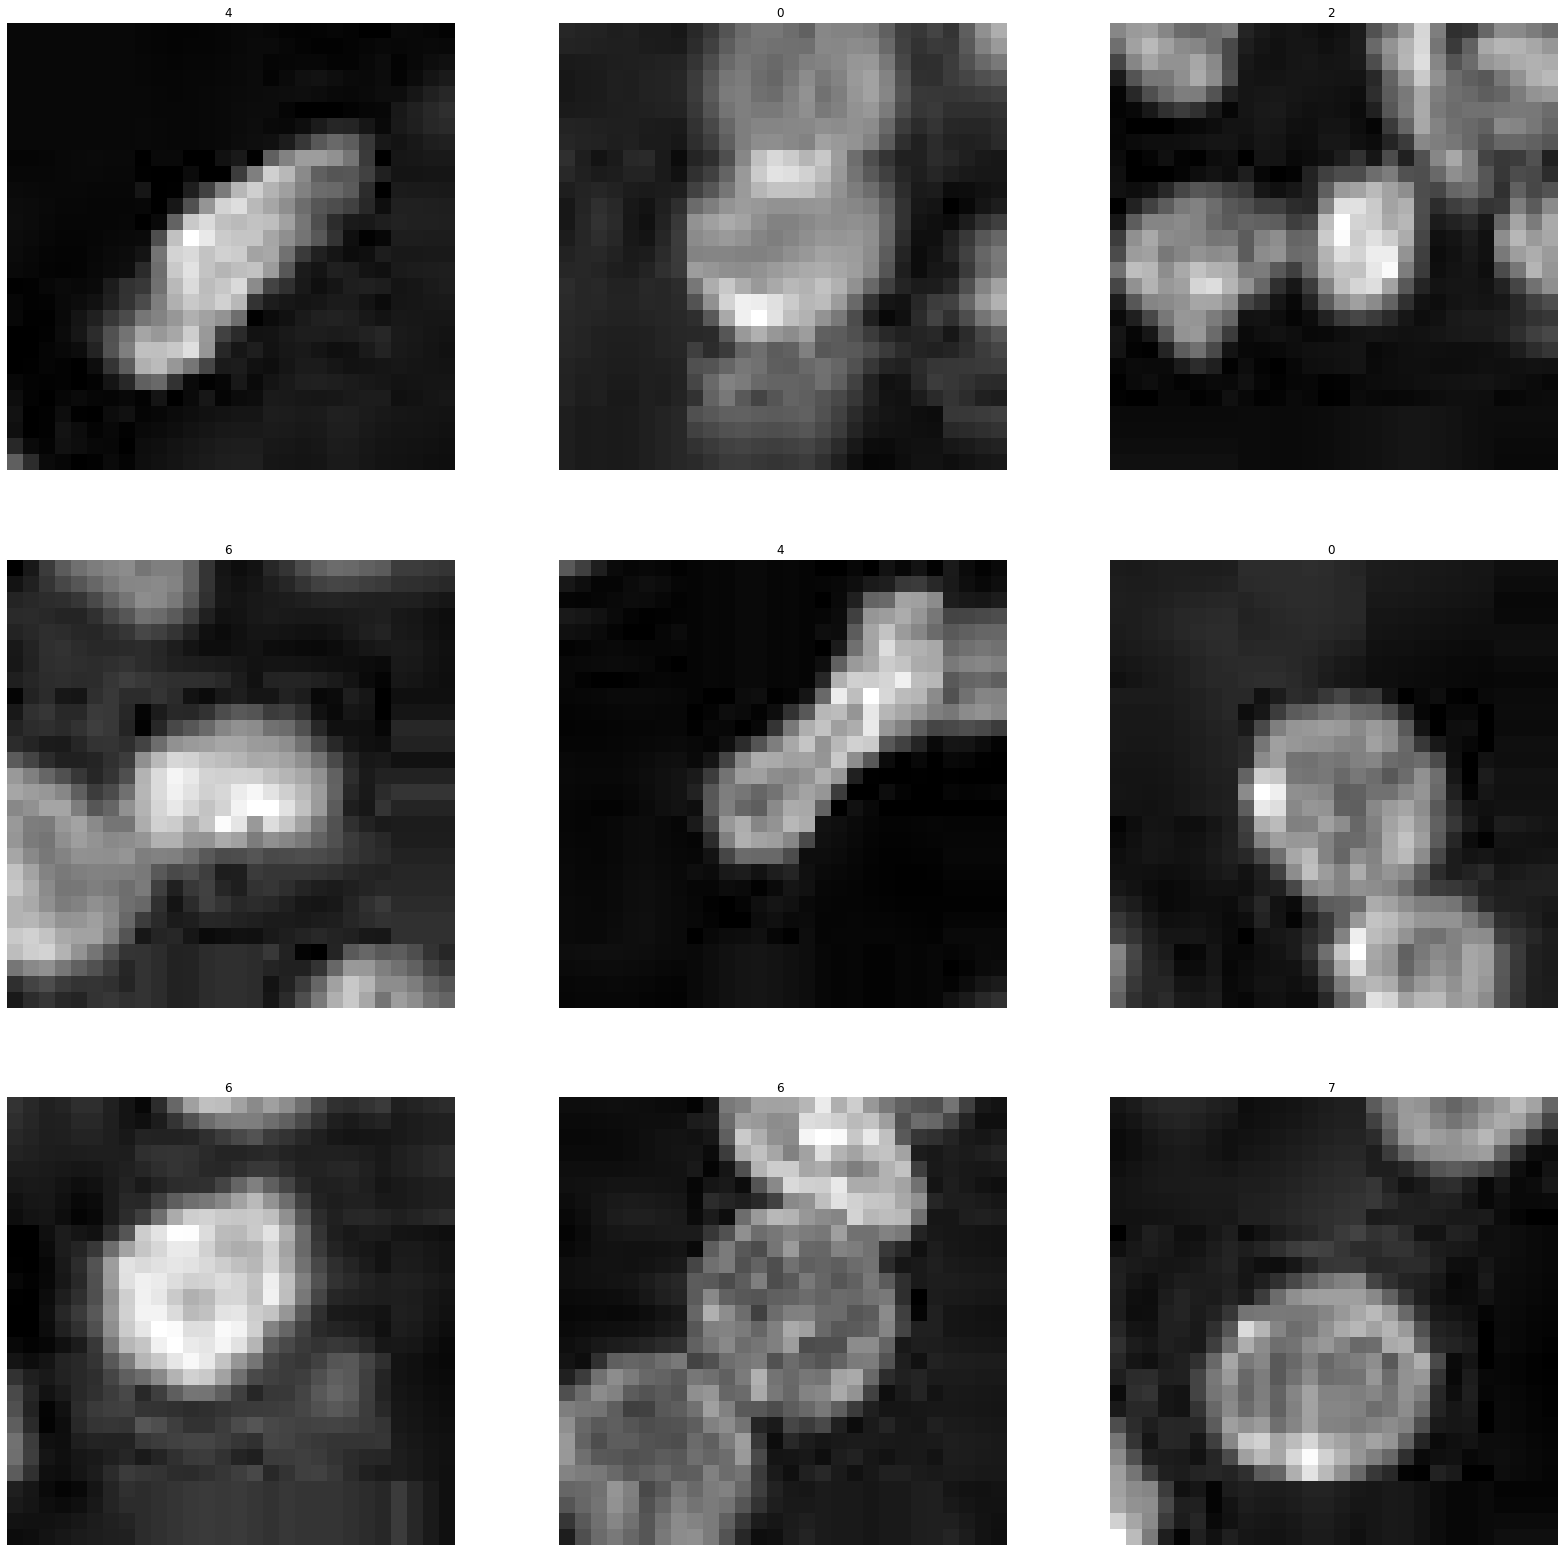

In [8]:
# Show some images
#image_batch, label_batch, path_batch = next(iter(train_ds))
image_batch, d, label_batch  = next(iter(train_ds))

plt.figure(figsize=image_size)
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray')

  label = label_batch[i]
  path = ""#str(path_batch[i].numpy())

  plt.title(str(label.numpy()) + " " + path)
  plt.axis("off")


Read the testing set

In [9]:
test_ds = image_dataset_from_directory(
  './test', 
  labels=None, 
  shuffle=False,
  color_mode=color_mode,
  batch_size=batch_size,
  image_size=image_size)

Found 50000 files belonging to 1 classes.


Create a model

In [55]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(padding='same', strides=(1, 1)))
    model.add(layers.AveragePooling2D(padding='same', strides=(1, 1)))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

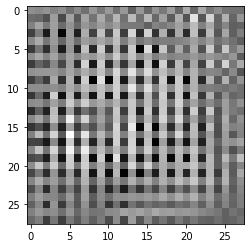

In [56]:
generator = make_generator_model()

noise = tf.random.normal([75])
rest = np.array([*np.array([1] * 25), *noise])
#print(rest)
generated_image = generator(np.array([rest]), training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [28]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=(image_shape)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    for _ in range(4):
        model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(400))
    model.add(layers.Dense(200))
    model.add(layers.Dense(1))

    return model

In [13]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00017731]], shape=(1, 1), dtype=float32)


In [14]:
#loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
binary = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(target, real_output, fake_output):
    real1_loss = binary(tf.ones_like(real_output), real_output)
    fake1_loss = binary(tf.zeros_like(fake_output), fake_output)

    return real1_loss + fake1_loss

In [16]:
def generator_loss(target, fake_output):
    fake1_loss = binary(tf.ones_like(fake_output), fake_output)

    return fake1_loss

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [18]:
EPOCHS = 50

In [22]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(y, r1, images):
    noise = tf.random.normal([batch_size, 50])
    rest = tf.concat([r1, noise], 1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(rest, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(y, fake_output)
        disc_loss = discriminator_loss(y, real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [25]:
import time

def train(dataset, epochs):

    for epoch in range(epochs):
        print(f"start {epoch}")
        start = time.time()
        for image_batch, r1, y  in dataset:
            train_step(np.array(tf.keras.utils.to_categorical(y)), r1, image_batch)
        
        print("generated cell 1 image")
        noise = tf.random.normal([50])
        rest = np.array([*np.array([1] * 50), *noise])
        #print(rest)
        generated_image = generator(np.array([rest]), training=False)
        plt.imshow(generated_image[0, :, :, 0], cmap='gray')
        plt.show()
        
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


training cat
start 0
generated cell 1 image


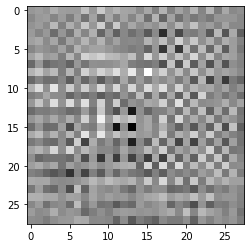

Time for epoch 1 is 34.35408401489258 sec
start 1
generated cell 1 image


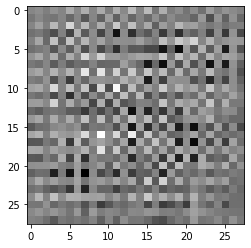

Time for epoch 2 is 35.98742723464966 sec
start 2
generated cell 1 image


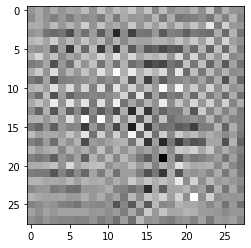

Time for epoch 3 is 40.27361440658569 sec
start 3
generated cell 1 image


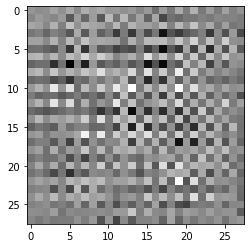

Time for epoch 4 is 41.477205753326416 sec
start 4
generated cell 1 image


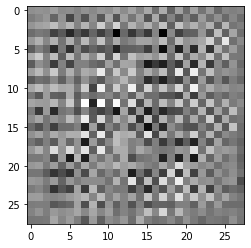

Time for epoch 5 is 41.028684854507446 sec
start 5
generated cell 1 image


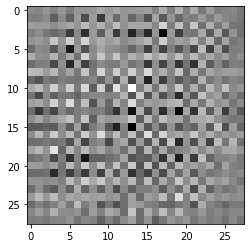

Time for epoch 6 is 41.233609437942505 sec
start 6
generated cell 1 image


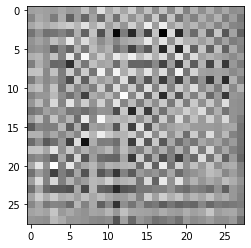

Time for epoch 7 is 40.28360104560852 sec
start 7
generated cell 1 image


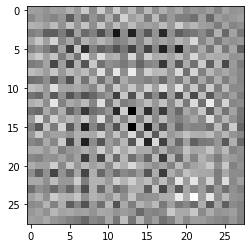

Time for epoch 8 is 41.25494170188904 sec
start 8


KeyboardInterrupt: 

In [45]:
#discriminator = make_discriminator_model()
#generator = make_generator_model()
#print("training eq")
#train1(train_ds, EPOCHS*5)
print("training cat")
train(train_ds, EPOCHS)

In [ ]:
noise = tf.random.normal([100])
rest = np.array([*np.array([0] * 100), *noise])
#print(rest)
generated_image = generator(np.array([rest]), training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [38]:
discriminator.save('disc.h5')
generator.save('gen.h5')

In [ ]:
predictions = [np.argmax(x) for x in model.predict(test_ds)]
predictions

In [14]:
from pandas import DataFrame
DataFrame(data={'Cell type': predictions}).to_csv('predictions.csv', index_label='Id')

In [15]:
!kaggle competitions submit -m $URN -c uos-com2028-21-22-cw -f predictions.csv

100%|█████████████████████████████████████████| 380k/380k [00:01<00:00, 240kB/s]
Successfully submitted to COM2028 21/22 CW